In [34]:
import operator

from SolrClient import SolrClient

import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from treetagger import TreeTagger

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pedro.castro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
solr = SolrClient('http://montserrat03:8080/easysearch')

In [3]:
res = solr.query('default',{
            'q': '-ctr_id:id_document_spell',
            'indent': 'true',
            'fl': 'ctr_id,api_Nome_do_arquivo_tg,api_Conteúdo_tg,api_Título_tg',
            'wt': 'json',
            'rows': '2147483647'
    })

In [4]:
res.get_results_count()

3387

In [5]:
res.docs[0]

{'api_Conteúdo_tg': 'A Pró-Reitora de Gestão e Desenvolvimento de Pessoas da\nUniversidade Federal de São João del-Rei - UFSJ, no uso de suas\natribuições, HOMOLOGA o concurso público para provimento de\ncargo da Carreira de Magistério Superior, CPD 051/2016, na área de\nDERMATOLOGIA, para o Departamento de Medicina (DEMED),\nEdital publicado no DOU do dia 01/08/2016 e torna público seu\nresultado, a saber: 1º LUGAR: VALÉRIA AZEVEDO JUNQUEIRA;\n2° LUGAR: MAHYRA LEITE RIBEIRO.\nEm 28 de setembro de 2016',
 'api_Nome_do_arquivo_tg': 'DO3_2016_09_29_1001.xml',
 'api_Título_tg': 'EDITAL DE HOMOLOGAÇÃO CPD Nº 51/2016',
 'ctr_id': 'da77343019c27110cf9ace0925c6b35cdae2cd6a'}

In [6]:
res.docs[0]['api_Conteúdo_tg']

'A Pró-Reitora de Gestão e Desenvolvimento de Pessoas da\nUniversidade Federal de São João del-Rei - UFSJ, no uso de suas\natribuições, HOMOLOGA o concurso público para provimento de\ncargo da Carreira de Magistério Superior, CPD 051/2016, na área de\nDERMATOLOGIA, para o Departamento de Medicina (DEMED),\nEdital publicado no DOU do dia 01/08/2016 e torna público seu\nresultado, a saber: 1º LUGAR: VALÉRIA AZEVEDO JUNQUEIRA;\n2° LUGAR: MAHYRA LEITE RIBEIRO.\nEm 28 de setembro de 2016'

In [7]:
def preprocess_texts(texts, text_field):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    for text in texts:
        yield gensim.utils.simple_preprocess(text[text_field], deacc=True, min_len=3)

In [8]:
train_texts = list(preprocess_texts(res.docs, 'api_Conteúdo_tg'))

In [9]:
tt = TreeTagger(language='portuguese')
tt.tag('Olá, tudo bem com vocês?')

[['Olá', 'NCMS', 'olá'],
 [',', 'Fc', ','],
 ['tudo', 'PI0', 'tudo'],
 ['bem', 'RG', 'bem'],
 ['com', 'SPS', 'com'],
 ['vocês', 'PP3', 'você'],
 ['?', 'Fit', '?']]

In [10]:
def lemmatize(text, language='portuguese'):
    tt = TreeTagger(language=language)
    lemmas = tt.tag(text)
    return [tuples[0] if tuples[2] == '<unknown>' else tuples[2] for tuples in lemmas]
print(lemmatize('Olá, tudo bem com vocês?'))

['olá', ',', 'tudo', 'bem', 'com', 'você', '?']


In [11]:
def process_texts(texts, language='portuguese'):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    stops = set(stopwords.words(language))
    #texts = [[word for word in word_tokenize(text) if word.lower() not in stops] for text in texts]
    texts = [[word for word in text if word not in stops] for text in texts]
    print('Textos removendo stopwords', texts[0])
    
    phrases = gensim.models.Phrases(texts)
    bigram = gensim.models.phrases.Phraser(phrases)
    texts = [bigram[line] for line in texts]
    print('Textos a partir de bigrams', texts[0])
    
    texts = [[word for word in lemmatize(line, language=language)] for line in texts]
    print('Textos lematizados', texts[0])
    return texts

In [12]:
train_texts = process_texts(train_texts)
train_texts[0:2]

Textos removendo stopwords ['pro', 'reitora', 'gestao', 'desenvolvimento', 'pessoas', 'universidade', 'federal', 'sao', 'joao', 'del', 'rei', 'ufsj', 'uso', 'atribuicoes', 'homologa', 'concurso', 'publico', 'provimento', 'cargo', 'carreira', 'magisterio', 'superior', 'cpd', 'area', 'dermatologia', 'departamento', 'medicina', 'demed', 'edital', 'publicado', 'dou', 'dia', 'torna', 'publico', 'resultado', 'saber', 'lugar', 'valeria', 'azevedo', 'junqueira', 'lugar', 'mahyra', 'leite', 'ribeiro', 'setembro']
Textos a partir de bigrams ['pro_reitora', 'gestao', 'desenvolvimento_pessoas', 'universidade_federal', 'sao_joao', 'del_rei', 'ufsj_uso', 'atribuicoes_homologa', 'concurso_publico', 'provimento', 'cargo', 'carreira_magisterio', 'superior_cpd', 'area', 'dermatologia', 'departamento_medicina', 'demed_edital', 'publicado_dou', 'dia', 'torna_publico', 'resultado', 'saber_lugar', 'valeria', 'azevedo', 'junqueira', 'lugar', 'mahyra', 'leite', 'ribeiro', 'setembro']
Textos lematizados ['pro_

[['pro_reitora',
  'gestao',
  'desenvolvimento_pessoas',
  'universidade_federal',
  'sao_joao',
  'del_rei',
  'ufsj_uso',
  'atribuicoes_homologa',
  'concurso_publico',
  'provimento',
  'cargo',
  'carreira_magisterio',
  'superior_cpd',
  'area',
  'dermatologia',
  'departamento_medicina',
  'demed_edital',
  'publicado_dou',
  'dia',
  'torna_publico',
  'resultar',
  'saber_lugar',
  'valer',
  'azevedo',
  'junqueira',
  'lugar',
  'mahyra',
  'leite',
  'ribeiro',
  'setembro'],
 ['processo',
  'uasg',
  'pregao_eletronico',
  'srp',
  'objetar',
  'registro_precos',
  'eventual_aquisicao',
  'material',
  'biologicos',
  'farmacologicos',
  'hospitalar',
  'veterinario',
  'visar',
  'suprir_necessidades',
  'diversas_unidades',
  'campus',
  'universidade_federal',
  'sergipe',
  'orgaos',
  'participante',
  'maternidade',
  'escola',
  'assis',
  'chateaubriand',
  'uasg',
  'hosp',
  'profº',
  'edgard',
  'santo',
  'ufba',
  'uasg',
  'data_assinatura',
  'ata_vigenci

In [15]:
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

In [16]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [18]:
import pyLDAvis.gensim

In [19]:
pyLDAvis.enable_notebook()

In [20]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      13.960880        1       1  0.027152  0.069696
0      13.461152        1       2  0.157988 -0.012896
4      13.383212        1       3 -0.043125  0.077367
5      12.476622        1       4 -0.077302 -0.009930
9      10.602826        1       5 -0.100604 -0.007964
2       8.727472        1       6  0.081697  0.037552
7       7.614148        1       7 -0.020203 -0.007695
1       7.195683        1       8 -0.041694  0.000330
8       6.821659        1       9  0.002166 -0.063134
6       5.756347        1      10  0.013925 -0.083326, topic_info=      Category         Freq                     Term        Total  loglift  \
term                                                                         
13572  Default   455.000000               vigor_data   455.000000  30.0000   
63     Default  1051.000000                     item  1051.000000  29.0000   
8325   Default   256.000000       juizados_especiais   256.000000  28.0000   
10755  Default   193.000000        federais_processo   193.000000  27.0000   
4621   Default   269.000000         publicada_diario   269.000000  26.0000   
11785  Default   255.000000          uso_competencia   255.000000  25.0000   
13426  Default   194.000000           ocupante_cargo   194.000000  24.0000   
9288   Default   216.000000             lei_dezembro   216.000000  23.0000   
6561   Default   243.000000               requerente   243.000000  22.0000   
30     Default  1852.000000                 processo  1852.000000  21.0000   
7919   Default   293.000000           quadro_pessoal   293.000000  20.0000   
9536   Default   147.000000            inciso_alinea   147.000000  19.0000   
310    Default   503.000000              valor_total   503.000000  18.0000   
14098  Default   235.000000              resolve_art   235.000000  17.0000   
193    Default   255.000000           comprasnet_gov   255.000000  16.0000   
407    Default   333.000000            oficial_uniao   333.000000  15.0000   
18294  Default   465.000000                 proc_adv   465.000000  14.0000   
192    Default   318.000000                 site_www   318.000000  13.0000   
14265  Default   132.000000        superior_tribunal   132.000000  12.0000   
583    Default  1610.000000                      art  1610.000000  11.0000   
292    Default   513.000000                contratar   513.000000  10.0000   
9852   Default    99.000000           previsao_legal    99.000000   9.0000   
11319  Default   128.000000             vista_consta   128.000000   8.0000   
232    Default   715.000000                  federal   715.000000   7.0000   
321    Default   735.000000                     cnpj   735.000000   6.0000   
6273   Default   117.000000      resolucao_diretoria   117.000000   5.0000   
8081   Default   265.000000                      oab   265.000000   4.0000   
18262  Default   344.000000           turma_recursal   344.000000   3.0000   
78     Default   733.000000                     ltda   733.000000   2.0000   
18257  Default   348.000000  incidente_uniformizacao   348.000000   1.0000   
...        ...          ...                      ...          ...      ...   
449    Topic10    29.568554          numero_contrato    96.275517   1.6744   
10136  Topic10    25.884534      considerando_consta    79.500923   1.7327   
460    Topic10    30.417012                    sicon   106.357453   1.6031   
266    Topic10    39.949064          cnpj_contratado   165.120773   1.4358   
58     Topic10    67.760582          data_assinatura   387.317935   1.1116   
309    Topic10    26.483228             lei_vigencia    95.613670   1.5711   
155    Topic10    64.084248                 servicos   424.639661   0.9638   
306    Topic10    47.832721         fundamento_legal   273.382779   1.1117   
65     Topic10    76.956581                  empresa   631.681793   0.7497   
292    Topic10    68.179712      

In [21]:
ldatopics = ldamodel.show_topics(formatted=False)

In [22]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

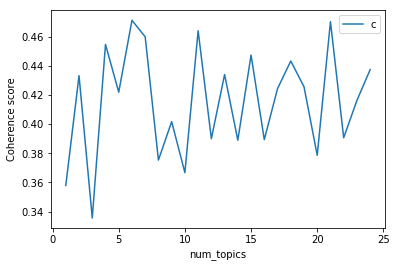

CPU times: user 7min 4s, sys: 49 s, total: 7min 53s
Wall time: 7min 4s


In [26]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=25)

In [30]:
print(c_v)
print(c_v[20])

[0.35794735577379438, 0.43320701894116553, 0.33561377070433246, 0.45461888331214539, 0.42187944113295039, 0.47111866015823289, 0.45982510209948269, 0.3753266951516856, 0.40167254078071057, 0.36671155311001546, 0.46398103656763268, 0.38997422522215225, 0.4339709671252221, 0.38895926357030131, 0.44726429307370813, 0.38935341098813336, 0.42428577129512324, 0.44322437460348874, 0.42562619967796317, 0.37859929446809409, 0.47020432861560896, 0.39064884627588231, 0.41621347680584841, 0.437344682402591]
0.470204328616


In [31]:
pyLDAvis.gensim.prepare(lmlist[20], corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      10.781085        1       1  0.297431 -0.047168
15      7.896076        1       2  0.051885  0.115930
13      7.157226        1       3 -0.001697  0.019409
0       7.121554        1       4 -0.100575 -0.032407
11      7.061163        1       5 -0.044252  0.080158
14      6.945204        1       6 -0.065356  0.058737
5       6.183001        1       7 -0.097524 -0.080522
17      5.305591        1       8 -0.038956  0.076547
4       4.881627        1       9 -0.020467  0.059092
6       4.755855        1      10 -0.065668 -0.002403
2       4.665643        1      11 -0.087916 -0.085206
18      3.433556        1      12  0.045516  0.030590
1       3.310979        1      13 -0.032947 -0.004142
19      2.892005        1      14  0.002905 -0.072669
8       2.811320        1      15  0.002897  0.061008
9       2.706433        1      16 -0.068263 -0.051201
12      2.593273        1      17  0.059545 -0.028251
20      2.483421        1      18  0.173226 -0.011121
16      2.460281        1      19 -0.010234 -0.019665
10      2.448187        1      20 -0.016458 -0.012271
3       2.106519        1      21  0.016908 -0.054445, topic_info=      Category         Freq                     Term        Total  loglift  \
term                                                                         
63     Default   921.000000                     item   921.000000  30.0000   
13572  Default   425.000000               vigor_data   425.000000  29.0000   
14098  Default   357.000000              resolve_art   357.000000  28.0000   
8081   Default   206.000000                      oab   206.000000  27.0000   
11785  Default   183.000000          uso_competencia   183.000000  26.0000   
8325   Default   190.000000       juizados_especiais   190.000000  25.0000   
10755  Default   149.000000        federais_processo   149.000000  24.0000   
6561   Default   262.000000               requerente   262.000000  23.0000   
6983   Default   213.000000   fiscalizacao_ambiental   213.000000  22.0000   
9288   Default   161.000000             lei_dezembro   161.000000  21.0000   
7919   Default   261.000000           quadro_pessoal   261.000000  20.0000   
4621   Default   247.000000         publicada_diario   247.000000  19.0000   
13426  Default   185.000000           ocupante_cargo   185.000000  18.0000   
18294  Default   402.000000                 proc_adv   402.000000  17.0000   
5830   Default   160.000000              confere_art   160.000000  16.0000   
9852   Default   118.000000           previsao_legal   118.000000  15.0000   
321    Default   701.000000                     cnpj   701.000000  14.0000   
8428   Default   253.000000         secao_judiciaria   253.000000  13.0000   
310    Default   500.000000              valor_total   500.000000  12.0000   
30     Default  1939.000000                 processo  1939.000000  11.0000   
78     Default   728.000000                     ltda   728.000000  10.0000   
4430   Default    89.000000                    turma    89.000000   9.0000   
192    Default   387.000000                 site_www   387.000000   8.0000   
193    Default   321.000000           comprasnet_gov   321.000000   7.0000   
18257  Default   303.000000  incidente_uniformizacao   303.000000   6.0000   
9536   Default    87.000000            inciso_alinea    87.000000   5.0000   
18262  Default   298.000000           turma_recursal   298.000000   4.0000   
583    Default  1833.000000                      art  1833.000000   3.0000   
3847   Default    82.000000     professor_magisterio    82.000000   2.0000   
2767   Default   574.000000                   codigo   574.000000   1.0000   
...        ...          ...                      ...          ...      ...   
4209   Topic21     7.796252                   marcus    17.300961   3.0630   
5589   Topic21    23.091698              identificar    83.6071

In [32]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LdaModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [ ]:
%%time
lm, top_topics = ret_top_model()